<a href="https://colab.research.google.com/github/Passonei/Yoga_positions_classification/blob/main/yoga_positions_acc_96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Identifying different yoga poses using pose estimation

In this task, authors of other notebooks use CNNs and transfer learning to checkout individual yoga poses. I approached this task differently and used pose estimation to extract new features describing the position of body points. 33 points are extracted, each of which is described by 4 values (3 position coordinates and visibility). Random Forest is then used for classification.
After applying SMOTE additively, the accuracy of the model is ~96%.

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 30.1 MB/s eta 0:00:00


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing)
import os
import IPython #display picture
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from PIL import Image #load picture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [ ]:
seed = 333
image_path = []
label = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if not filename.endswith('.json'):
            image_path.append(os.path.join(dirname, filename))
            label.append(os.path.split(dirname)[1])

In [ ]:
image_path = pd.Series(image_path, name='path')
label = pd.Series(label, name='label')
df = pd.concat([image_path,label], axis=1)

In [ ]:
labels=[]
X=[]

for i in range(len(df)):
    img = Image.open(df['path'][i])
    img = img.resize((128, 128))
    img = np.array(img)
    if len(img.shape)>2 and img.shape[2] == 4:
        img = img[:, :, :3]
    elif len(img.shape)<3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if img.shape[2] == 3:
        X.append(img)
        labels.append(df['label'][i])

In [ ]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(labels)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


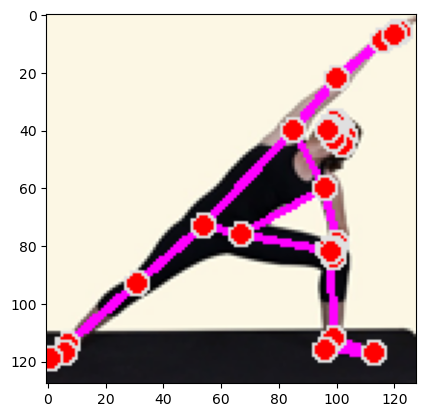

In [ ]:
mp_pose = mp.solutions.pose
mp_draw = mp.solutions.drawing_utils
pose = mp_pose.Pose()

img = X[333]
results = pose.process(img)
mp_draw.draw_landmarks(img, results.pose_landmarks,
                        mp_pose.POSE_CONNECTIONS,
                        mp_draw.DrawingSpec((255, 0, 0), 2, 2),
                        mp_draw.DrawingSpec((255, 0, 255), 2, 2)
                       )
plt.imshow(img)

In [ ]:
x_position = np.zeros((len(X),33,4))
y_position = np.zeros(label_encoded.shape)
x_position.shape, y_position.shape

((2756, 33, 4), (2756,))

Extraction of new features from the images as coordinates of selected body points

In [ ]:
for i in range(len(X)):
    results = pose.process(X[i])
    if results.pose_landmarks is not None:
        positions = results.pose_landmarks.landmark
        j=0
        for landmark in positions:
            x = landmark.x
            y = landmark.y
            z = landmark.z
            v = landmark.visibility
            x_position[i,j] = [x,y,z,v]
            y_position[i] = label_encoded[i]+1
            j+=1

Dropping of images for which no points could be estimated

In [ ]:
non_zero_mask = np.any(x_position != 0, axis=(1,2))
x_position = x_position[non_zero_mask]
y_position = y_position[y_position != 0]

y_position.shape, x_position.shape

((2528,), (2528, 33, 4))

In [ ]:
x_position = x_position.reshape(x_position.shape[0],x_position.shape[1]*x_position.shape[2])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_position, y_position,
                                                    test_size=0.2, shuffle=True,
                                                    random_state=seed)

Class balancing using SMOTE (Synthetic Minority Over-sampling Technique)

In [ ]:
smote = SMOTE(random_state=seed, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
forest = RandomForestClassifier(n_estimators=200,random_state=seed)

forest.fit(X_resampled, y_resampled)

y_pred = forest.predict(X_test)
accuracy_score(y_test, y_pred)

0.9644268774703557